In [1]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [212]:
# Print the versions of pytorch
print(torch.__version__)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2.4.1+cu121
cuda


# Data

In [2]:
path = r'TF_HLC'

In [126]:
# Load data
freq_data = np.genfromtxt(os.path.join(path,"TTF_freq_200.csv"), delimiter=",")

# Load pickle
with open(os.path.join(path,"TTF_data_200.pt"), "rb") as f:
    TTF_data = pickle.load(f)

with open(os.path.join(path,"Vs_values_200.pt"), "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

print(TTF_data.shape, Vs_data.shape,freq_data.shape)

freq_vals = freq_data


(1000, 200) (1000, 29) (200,)


In [175]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values, freq_values=None):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        self.freq_values = freq_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):
        
        # Target data
        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32)

        # Input data
        input_data = self.Vs_values[idx]
        input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0)
        input_data = torch.nan_to_num(input_data, nan=0.0, posinf=0.0, neginf=0.0)

        return input_data, target_data

In [ ]:
dataset = TTF_dataset(TTF_data, Vs_data, freq_values=None)
print("Sizes in the dataset: ", len(dataset))
print("Data shapes for input and target: ", dataset[0][0].shape, dataset[0][1].shape)

Sizes in the dataset:  1000
Data shapes for input and target:  torch.Size([1, 29]) torch.Size([200])


In [177]:
# Separate into training and testing
train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " , train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))
print("Training shapes: ", next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape)

Train, validation and test sizes:  700 150 150
Number of batches:  70 15 15
Training shapes:  torch.Size([10, 1, 29]) torch.Size([10, 200])


# Model architecture

In [178]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [179]:
class CN1D(nn.Module):
    def __init__(self, input_dim, kernel_size=3, pooling=nn.MaxPool1d, activation=nn.ReLU, cn_layer_list=[32, 64, 128]):
        super(CN1D, self).__init__()
        self.cn_layers = nn.ModuleList()
        self.pooling = pooling
        self.activation = activation
        self.input_dim = input_dim

        # Input layer
        self.cn_layers.append(nn.Conv1d(1, cn_layer_list[0], kernel_size))
        self.cn_layers.append(self.pooling(kernel_size=2))
        self.cn_layers.append(self.activation())

        # Hidden layers
        for i in range(1, len(cn_layer_list)):
            self.cn_layers.append(nn.Conv1d(cn_layer_list[i-1], cn_layer_list[i], kernel_size))
            self.cn_layers.append(self.pooling(kernel_size=2))
            self.cn_layers.append(self.activation())
        
    def forward(self, x):
        for layer in self.cn_layers:
            x = layer(x)
        return x
    

In [189]:
class OutputModel(nn.Module):
    def __init__(self):
        super(OutputModel, self).__init__()
        self.Vs_model = CN1D(29)
        self.outmlp = MLP(128+1, output_dim=1, hidden_dim=128, hidden_layers=3, batch_norm=False)

    def forward(self, x, freq_tensor):
        x = self.Vs_model(x)
        x = x.view(x.size(0), -1)
        result = []
        for i, freq_i in enumerate(freq_tensor):
            freq_i = torch.repeat_interleave(freq_i.unsqueeze(0), x.size(0), dim=0)
            x_freq = torch.cat((x, freq_i), dim=1)
            x_freq = self.outmlp(x_freq)
            result.append(x_freq)

        result = torch.stack(result, dim=1).squeeze(2)
        return result

In [211]:
model = OutputModel()

# Example input data
X, y = next(iter(train_loader))

# Example frequency data
freq = torch.tensor(freq_vals, dtype=torch.float32).unsqueeze(1)

# Forward pass
output = model(X, freq)

print("Output shape: ", output.shape)

# Define loss function
criterion = nn.L1Loss()

Output shape:  torch.Size([10, 200])


In [ ]:
# Define model
model = OutputModel()
freq = torch.tensor(freq_vals, dtype=torch.float32).unsqueeze(1)

# Criterion
criterion = nn.L1Loss()

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-4, amsgrad=True, 
eps=1e-08, betas=(0.7, 0.999))

# Training loop
n_epochs = 10
train_losses = []
val_losses = []

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Move frequency tensor to device
freq = freq.to(device)



# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, freq)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, freq)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} - Train loss: {train_loss:.4f} - Validation loss: {val_loss:.4f}")


Epoch 1/10 - Train loss: 2.0062 - Validation loss: 1.8078
Epoch 2/10 - Train loss: 1.5866 - Validation loss: 1.5702
Epoch 3/10 - Train loss: 1.5389 - Validation loss: 1.5502
Epoch 4/10 - Train loss: 1.5381 - Validation loss: 1.5447
Epoch 5/10 - Train loss: 1.5156 - Validation loss: 1.5169
Epoch 6/10 - Train loss: 1.5112 - Validation loss: 1.5492
Epoch 7/10 - Train loss: 1.4835 - Validation loss: 1.5010
Epoch 8/10 - Train loss: 1.4741 - Validation loss: 1.4882
Epoch 9/10 - Train loss: 1.4739 - Validation loss: 1.4905
Epoch 10/10 - Train loss: 1.4714 - Validation loss: 1.4854


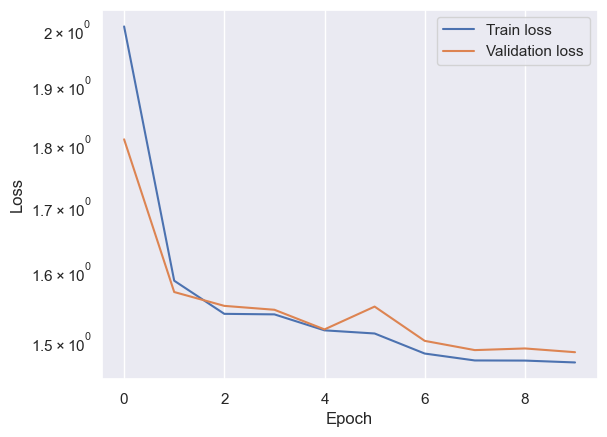

In [198]:
# Plot the losses
plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()

In [204]:
# Predict for test data
model.eval()
test_predictions = []
test_targets = []
test_inputs = []
test_loss = 0.0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, freq)
        test_predictions.append(outputs)
        test_targets.append(targets)
        test_inputs.append(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

test_loss /= len(test_loader)

print(f"Test loss: {test_loss:.4f}")


Test loss: 1.4329


In [205]:
test_predictions = torch.cat(test_predictions, dim=0).cpu().numpy()
test_targets = torch.cat(test_targets, dim=0).cpu().numpy()
test_inputs = torch.cat(test_inputs, dim=0).cpu().numpy()


In [207]:
len(test_loader)

15

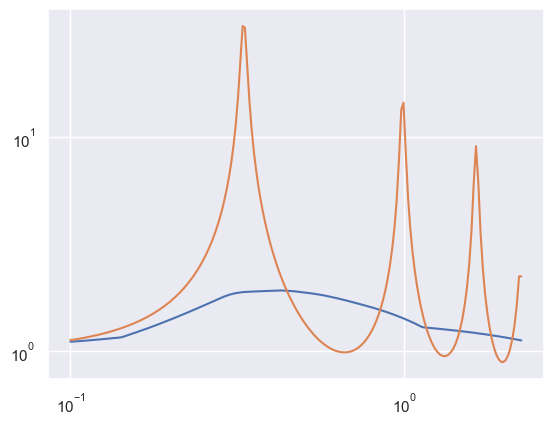

In [210]:
plt.loglog(freq_vals, test_predictions[0])
plt.loglog(freq_vals, test_targets[0])

In [161]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [163]:
from tqdm import trange, tqdm

def train_model(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", 
patience=50, clipping=True, print_epoch=10, freq_data=None):
    """
    Train a PyTorch model with early stopping and learning rate scheduler.
    
    Args:
    model: PyTorch model
    optimizer: PyTorch optimizer
    scheduler: PyTorch learning rate scheduler
    train_dataloader: PyTorch DataLoader for training data
    validation_dataloader: PyTorch DataLoader for validation data
    loss_fn: PyTorch loss function
    epochs: Number of epochs to train
    device: PyTorch device, e.g. "cpu" or "cuda"
    patience: Patience for early stopping, i.e. number of epochs without improvement before stopping
    clipping: Whether to use gradient clipping
    print_epoch: Print training and validation loss every print_epoch epochs

    Returns:
    train_losses: List of training losses
    val_losses: List of validation losses
    model: Trained PyTorch model
    """
    
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    best_model = None
    freq_tensor = torch.tensor(freq_data, dtype=torch.float32).unsqueeze(1).to(device)

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X, freq_tensor)
            loss = loss_fn(y_pred, y)
            loss.backward()
            if clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X, freq_tensor)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % print_epoch == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model


def test_model(model, test_dataloader, loss_fn, device="cpu", freq_data=None):
    """
    Test a PyTorch model.
    Args:
    model: PyTorch model
    test_dataloader: PyTorch DataLoader for test data
    loss_fn: PyTorch loss function
    device: PyTorch device, e.g. "cpu" or "cuda"
    Returns:
    test_loss: Average test loss
    """
    
    model.eval()
    test_loss = 0
    freq_tensor = torch.tensor(freq_data, dtype=torch.float32).unsqueeze(1).to(device)
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, freq_tensor)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [164]:
import torch
import torch.optim as optim
import torch.nn as nn

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-4, amsgrad=True, 
eps=1e-08, betas=(0.7, 0.999))

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
patience=250, 
threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08)

# Training
num_epochs = 20000
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = nn.L1Loss()

# Join L1Loss and cosine similarity
def custom_loss(y_true, y_pred, alpha=0.5):
    l1_loss = loss_fn(y_true, y_pred)
    cosine_loss = 1 - torch.nn.functional.cosine_similarity(y_true, y_pred).mean()
    return alpha * l1_loss + (1 - alpha) * cosine_loss

Device:  cuda


In [165]:
train_losses, val_losses, model = train_model(model, optimizer, scheduler, train_loader, val_loader, loss_fn, 
epochs=1000, device=device, patience=500, clipping=True, print_epoch=100, freq_data=freq_vals)

Training:   0%|          | 0/1000 [00:22<?, ?epoch/s]

Epoch 0, Train Loss: nan, Val Loss: nan, LR: 0.005
Loss is nan
